## 2024 Open Science Data Challenge - Sentinel-2  with Cloud Filtering

This notebook demonstrates extracting images from Sentinel-2 data which has 20m resolution with cloud filtering. This pixel-based approach is better than a scene-based approach since clouds are quite random for any given time and location. The results of this notebook can be employed to enhance the comprehension of the data or to generate additional training data. This can aid in the development of a machine learning model capable of detecting damaged and undamaged infrastructure. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the Microsoft Planetary Computer catalog.

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
import rioxarray as rio


# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load


# Pass your API key here
pc.settings.set_subscription_key('********************************')

### Load the satellite data
To load the satellite data, we define our area of interest using a bounding box. Bounding box needs to be defined in a specific format : (min longitude, min latitude, max longitude, max latitude), so be careful when entering the coordinates. Finally, we define the time window consistent in which natural disaster occured.

In [2]:
# Defining the Region of Interest
bounds = (-66.1938588694226,18.27471974898704,-66.08007533079798,18.478571816747003)

In [3]:
# Define the time window
time_window="2017-08-01/2017-11-30"

Using the `pystac_client` we can search the Planetary Computer's STAC catalog for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes and may contain clouds. 

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(collections=["sentinel-2-l2a"], bbox=bounds, datetime=time_window)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 45


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using the Open Data Cube (ODC) STAC [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html) library that is included with the Planetary Computer. The [ODC](https://www.opendatacube.org) is an open source geospatial data management and analysis software project that is used globally for many projects (e.g., Digital Earth Africa). The ODC-STAC code will load the selected items from the catalog search, select the desired spectral bands (including the SCL cloud filtering band), reproject into Lat-Lon coordinates (EPSG:4326) at 20-meters resolution (typical of Sentinel-2 pixel resolution), and clip the region to the spatial bounding box. 

In [5]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 20  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

In [6]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)

In [7]:
# View the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset>
Dimensions:      (latitude: 1135, longitude: 635, time: 24)
Coordinates:
  * latitude     (latitude) float64 18.48 18.48 18.48 ... 18.28 18.27 18.27
  * longitude    (longitude) float64 -66.19 -66.19 -66.19 ... -66.08 -66.08
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2017-08-01T15:07:19.027000 ... 2017-11...
Data variables:
    red          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 1135, 635), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 dask.array<chunksize=(1, 1135, 635), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 dask.array<chunksize=(1, 1135, 635), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 1135, 635), meta=np.ndarray>
    SCL          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 1135, 635), meta=np.ndarray>

### View RGB (real color) images from the time series

Data is available for Sentinel-2 from 2015 to now. Since this mission includes two satellites, it can view any location on the ground every 5 days. But, due to extreme cloud cover, some scenes are not even processed. For this example over 3 months, there are 24 time slices that touch our region. Unfortunately, there are no clear scenes and a minimal number of partially cloudy scenes. Also, some scenes appear to be "bright white" which means the region is completely covered with clouds but there were enough "good" pixels to process the image. Overall, the lack of clear scenes makes the use of optical data very challenging for any analysis. 

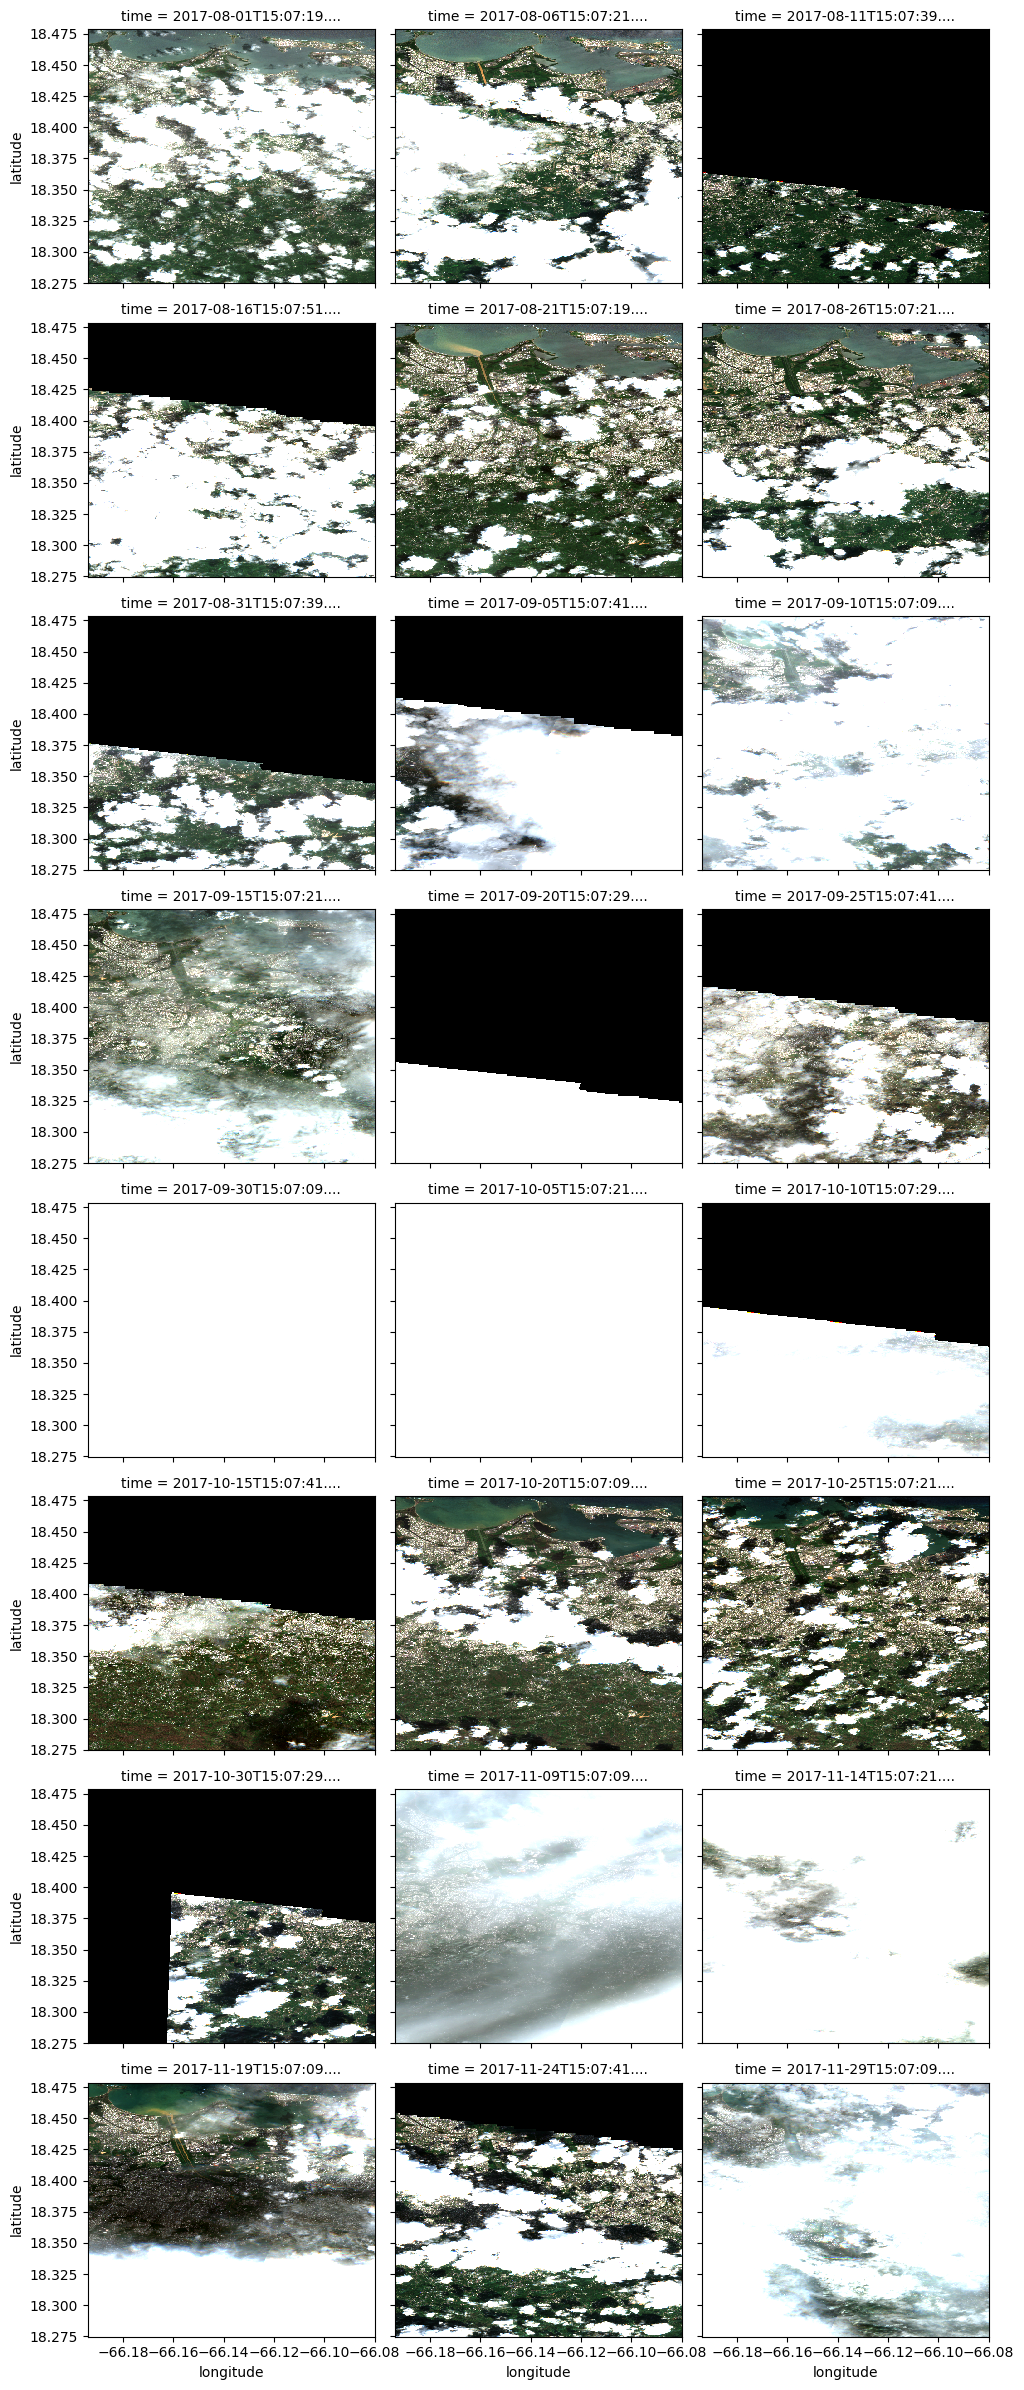

In [12]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=3, robust=True, vmin=0, vmax=3000)
plt.show()

In [1]:
# Select a time slice to view a simgle RGB image and the cloud mask
# See the XARRAY dimensions above for the number of time slices (starts at 0)

# Slice #17 - Scattered Clouds
# Slice #15 - Mostly Clear
# Slice #12 - Very Cloudy

time_slice = 17

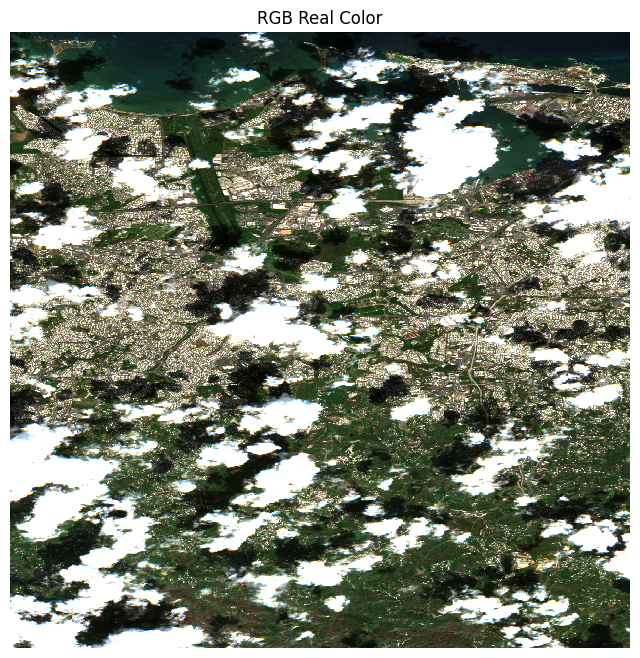

In [16]:
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
xx.isel(time=time_slice)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=3000)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

### Apply Cloud Filtering and Masking

In [17]:
# Filter data using the Sentinel-2 SCL band classification

# scl=0 > No Data
# scl=1 > Saturated
# scl=3 > Cloud Shadows
# scl=6 > Water 
# scl=8 > Cloud Medium Probability 
# scl=9 > Cloud High Probability
# scl=10 > Thin Cirrus Cloud

In [18]:
# Create a colormap to display the SCL pixel classifications

scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
)

In [19]:
def colorize(selected_data, colormap):
    return xr.DataArray(colormap[selected_data.data], coords=selected_data.coords, dims=(*selected_data.dims, "band"))

In [21]:
# Load SCL band, then convert to RGB using color scheme above
scl_rgba = colorize(xx.isel(time=time_slice).SCL.compute(), scl_colormap)

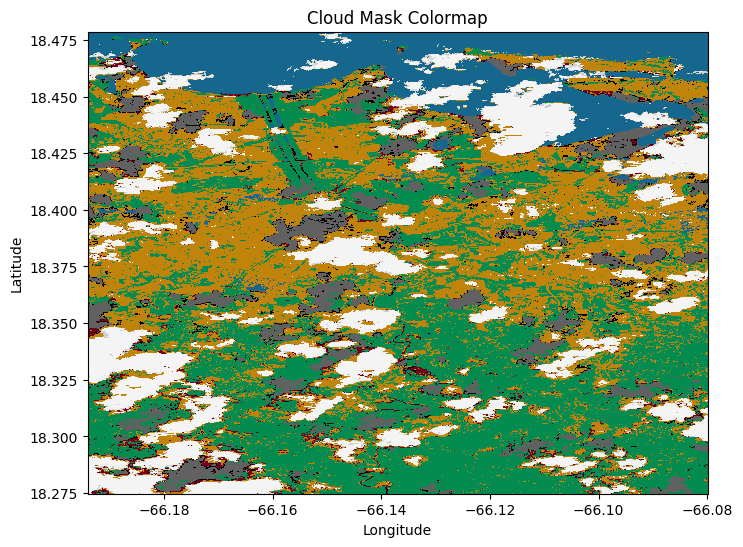

In [22]:
# Create an RGB plot of the SCL band
# Notice the clouds are bright white and the cloud shadows are grey

scl_rgba.plot.imshow(size=6)
plt.title("Cloud Mask Colormap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [23]:
# Create a mask for no data, saturated data, clouds, cloud shadows, and water

cloud_mask = \
    (xx.SCL != 0) & \
    (xx.SCL != 1) & \
    (xx.SCL != 3) & \
    (xx.SCL != 6) & \
    (xx.SCL != 8) & \
    (xx.SCL != 9) & \
    (xx.SCL != 10) 

In [25]:
# Apply cloud mask ... NO Clouds, NO Cloud Shadows and NO Water pixels
# All masked pixels are converted to "No Data" and stored as 16-bit integers
cleaned_data = xx.where(cloud_mask).astype("uint16")

In [26]:
# Load SCL band, then convert to RGB using color scheme above
scl_rgba_clean = colorize(cleaned_data.isel(time=time_slice).SCL.compute(), scl_colormap)

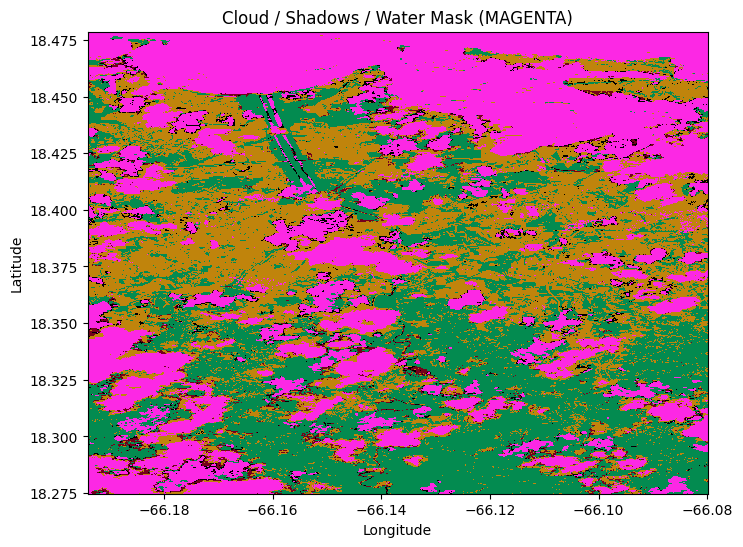

In [27]:
# Create an RGB plot of the SCL band
# Masked data (clouds/shadows/water) are shown in MAGENTA

scl_rgba_clean.plot.imshow(size=6)
plt.title("Cloud / Shadows / Water Mask (MAGENTA)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()